# Determiner la distribution d'un réseau d'eau

In [1]:
import numpy as np
from numpy.linalg import norm
# Import des données du problème
from TP_OC.Python.Probleme_R import n, m, mr, md, orig, dest, absn, ordn, r, pr, fd
from TP_OC.Python.Structures_N import Ar, Ad, AdT, AdI, AdC, B, q0

On remarque que dans la fonction à minimser, $q_c$ n'apparait que dans des structures de la forme $q^{(0)}+Bq_c$ donc on pose $ Q = q^{(0)} + Bq_c$

In [2]:
def F(q_c):
    Q = q0 + np.dot(B, q_c)
    return((1/3)* (np.dot(Q, r * Q * abs(Q)) + np.dot(pr, np.dot(Ar, Q))))

En calculant F(x+h) au second ordre en h, on obtient le gradient et la hessienne de F

In [3]:
def grad_F(q_c):
    """
    Peut-être rajouter un terme à multiplier pour la règle de la chaîne
    """
    Q = q0 + np.dot(B, q_c)
    return np.dot(np.transpose(B), r*Q*abs(Q)) + np.dot(np.transpose(np.dot(Ar, B)), pr)

In [4]:
def oraclePG(q_c, ind=4):
    if ind == 2 :
        return F(q_c)
    elif ind == 3 :
        return grad_F(q_c)
    elif ind == 4:
        return F(q_c), grad_F(q_c)

On test sur l'oracle.


Iteration : 4187
Temps CPU : 0.1006648779999999
Critere optimal : 7.936228345753166
Norme du gradient : 9.974936210514598e-07


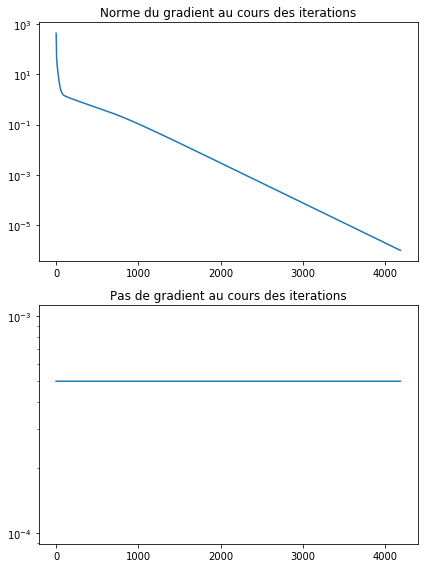

(7.936228345753166,
 array([-9.97488707e-07,  2.10134787e-09, -1.49918744e-10,  2.89155366e-11,
        -2.11820428e-09, -1.84091853e-10, -6.67473188e-10, -9.06141828e-11,
         6.24779339e-10]),
 array([ 0.31167056, -0.01749637,  0.16279675,  0.4306519 ,  0.03817885,
        -0.01562977, -0.15147633, -0.11908204,  0.18404951]))

In [5]:
from TP_OC.Python.Gradient_F import Gradient_F
Gradient_F(oraclePG, np.zeros(n - md))

In [23]:
def Hess_F(q_c):
    Q = q0 + B.dot(q_c)
    diago = np.diag(r*np.absolute(Q))
    return(2*np.dot(np.dot(np.transpose(B), diago,), B))

In [24]:
def oraclePH(q_c, ind=7):
    if ind == 2:
        return F(q_c)
    elif ind == 3:
        return grad_F(q_c)
    elif ind == 4:
        return F(q_c), grad_F(q_c)
    elif ind == 5:
        return Hess_F(q_c)
    elif ind == 6:
        return grad_F(q_c), Hess_F(q_c)
    elif ind == 7:
        return F(q_c), grad_F(q_c), Hess_F(q_c)


Iteration : 6
Temps CPU : 0.0020169320000000823
Critere optimal : 7.936228436722847
Norme du gradient : 1.951061536703236e-11


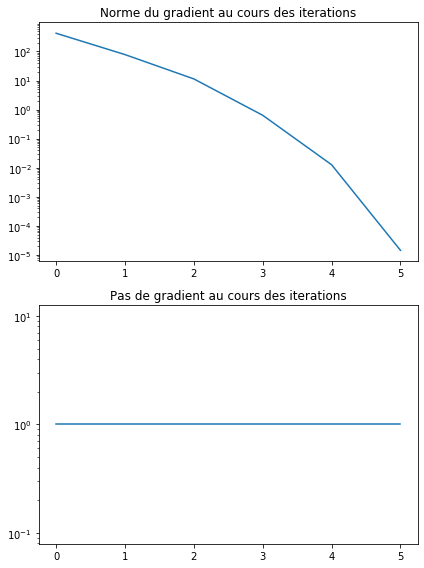

(7.936228436722847,
 array([ 0.00000000e+00,  3.70814490e-12,  3.25828253e-12,  2.29860575e-12,
         3.68527431e-12, -1.73674408e-11, -3.69482223e-12,  4.09672296e-12,
        -2.31725750e-12]),
 array([ 0.31167069, -0.01749637,  0.16279675,  0.4306519 ,  0.03817885,
        -0.01562977, -0.15147633, -0.11908204,  0.18404951]))

In [25]:
from TP_OC.Python.Newton_F import Newton_F
Newton_F(oraclePH, np.zeros(n - md))

In [28]:
def Wolfe(alpha, x, D, Oracle):
    
    ##### Coefficients de la recherche lineaire

    omega_1 = 0.1
    omega_2 = 0.9

    alpha_min = 0
    alpha_max = np.inf

    ok = 0
    dltx = 0.00000001

    ##### Algorithme de Fletcher-Lemarechal
    
    # Appel de l'oracle au point initial
    argout = Oracle(x)
    critere_x = argout[0]
    gradient_x = argout[1]

    # Initialisation de l'algorithme
    alpha_n = alpha
    xn = x
    
    # Boucle de calcul du pas
    # xn represente le point pour la valeur courante du pas,
    # xp represente le point pour la valeur precedente du pas.
    while ok == 0:
        
        # Point precedent pour tester l'indistinguabilite
        xp = xn
        
        # Point actuel
        xn = x + alpha_n*D
        critere_xn, gradient_xn = Oracle(xn, ind=4)
        
        # Calcul des conditions de Wolfe
        
        # Si l'on ne vérifie pas la première condition :
        if not critere_xn - critere_x <= omega_1 * alpha_n * np.dot(np.transpose(gradient_x), D):
            alpha_max = alpha_n
            alpha_n = 0.5 * (alpha_max + alpha_min)            
            
            
        else:
            # Si l'on ne vérie pas la seconde condition
            if not np.dot( np.transpose(gradient_xn), D)  >= omega_2 * np.dot(np.transpose(gradient), D):
                alpha_min = alpha_n
                if alpha_max == np.inf:
                    alpha_n = 2 * alpha_min
                else :
                    alpha_n = 0.5 * (alpha_max + alpha_min)
                
        # - Si les deux conditions de Wolfe sont verifiees,
        #   poser ok = 1 : on sort alors de la boucle while
            else:
                ok ==1 
            
        # - Sinon, modifier la valeur de alphan et reboucler

        
        # Test d'indistinguabilite
        if norm(xn - xp) < dltx:
            ok = 2

    return alpha_n, ok

In [29]:
def Gradient_pas_variable(Oracle, x0):

    ##### Initialisation des variables

    iter_max = 10000
    gradient_step = 0.0005
    threshold = 0.000001

    gradient_norm_list = []
    gradient_step_list = []
    critere_list = []

    time_start = process_time()

    x = x0

    ##### Boucle sur les iterations

    for k in range(iter_max):

        # Valeur du critere et du gradient
        critere, gradient = Oracle(x)

        # Test de convergence
        gradient_norm = norm(gradient)
        if gradient_norm <= threshold:
            break

        # Direction de descente
        direction = -gradient

        # Mise a jour des variables
        gradient_step, ok = Wolfe(gradient_step, x, direction, Oracle):
        
        x = x + (gradient_step * direction)

        # Evolution du gradient, du pas, et du critere
        gradient_norm_list.append(gradient_norm)
        gradient_step_list.append(gradient_step)
        critere_list.append(critere)

    ##### Resultats de l'optimisation

    critere_opt = critere
    gradient_opt = gradient
    x_opt = x
    time_cpu = process_time() - time_start

    print()
    print('Iteration :', k)
    print('Temps CPU :', time_cpu)
    print('Critere optimal :', critere_opt)
    print('Norme du gradient :', norm(gradient_opt))

    # Visualisation de la convergence
    Visualg(gradient_norm_list, gradient_step_list, critere_list)

    return critere_opt, gradient_opt, x_opt